In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as img
import torch
import torchvision
import torchvision.transforms as transform
import torch.nn.functional as f

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

%matplotlib inline

import os

In [2]:

import matplotlib.image as img
train_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/"
test_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/"
valid_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/"

In [3]:
batch_size = 64
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transform = transform.Compose([transform.Resize((224,224)),
                                      transform.CenterCrop(224),
                                      transform.ToTensor(),
                                      transform.Normalize(mean, std)
                                      ])

test_transform = transform.Compose([transform.Resize((224,224)),
                                      transform.ToTensor(),
                                      transform.Normalize(mean, std)
                                      ])

valid_transforms = transform.Compose([transform.Resize((224,224)),
                                      transform.ToTensor(),
                                      transform.Normalize(mean, std)
                                      ])
    

In [4]:
train_set = torchvision.datasets.ImageFolder(train_path, transform = train_transform)
test_set = torchvision.datasets.ImageFolder(test_path, transform = test_transform)
valid_set = torchvision.datasets.ImageFolder(valid_path,transform = valid_transforms)

In [5]:
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = False)
valid_loader = DataLoader(valid_set, batch_size = batch_size, shuffle = False)

In [6]:
data_iter = iter(train_loader)
images, labels = data_iter.next()
len(images)

64

In [8]:
label = train_set.class_to_idx
cat_to_name_train = {label[i]: i for i in list(label.keys())}

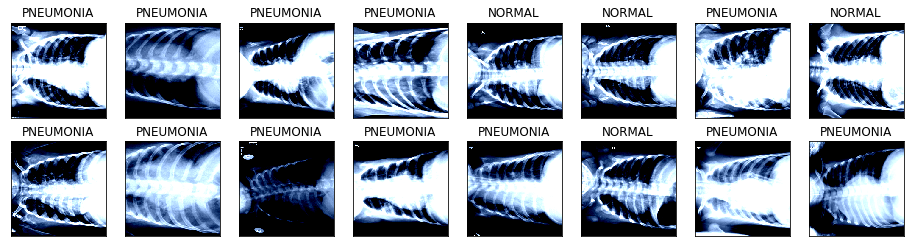

In [9]:
def showimage(data_loader, number_images,cat_to_name_train):
    dataiter = iter(data_loader)
    images, labels = dataiter.next()
    images = images.numpy() # convert images to numpy for display
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(number_images, 4))
    # display 16 images
    for idx in np.arange(number_images):
        ax = fig.add_subplot(2, number_images/2, idx+1, xticks=[], yticks=[])
        img = np.transpose(images[idx])
        plt.imshow(img)
        ax.set_title(cat_to_name_train[labels.tolist()[idx]])
showimage(train_loader,16,cat_to_name_train)

In [22]:
import torch.nn as nn
class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN,self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 32,4,4,0),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU())
        # (224-4 + 0) / 4  + 1 = 56
        # 32 * 56 * 56
        self.conv2 = nn.Sequential(nn.Conv2d(32,64, 4, 2,0),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU())
        # (56 - 4 + 0) / 2 + 1 = 28
        # 64 * 27 * 27
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, 5, 2,0),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU())
        # (27 - 5 + 0) / 2 + 1 = 11
        # 128 * 11 * 11
        self.conv4 = nn.Sequential(nn.Conv2d(128,256,5,2,0),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU())
        # (11 - 5 + 0) / 2 + 1 = 4
        # 256 * 4 * 4
        self.conv5 = nn.Sequential(nn.Conv2d(256,512,4,1,0),
                                   nn.BatchNorm2d(512),
                                   nn.ReLU())
        # (4 - 4 + 0) / 1 + 1 = 1
        # 512 * 1 * 1
        self.fc = nn.Sequential(nn.Linear(512 * 1 * 1, 784),
                              nn.ReLU(),
                              nn.Dropout(0.2),
                              nn.Linear(784,64),
                              nn.ReLU(),
                              nn.Dropout(0.2),
                              nn.Linear(64,2))
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [11]:
epochs = 10
learning_rate = 0.003
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [23]:
model = PneumoniaCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [24]:
for epoch in range(epochs):
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        preds = model(images)
        loss = criterion(preds, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Epoch: {}/{}, Loss: {}'.format(epoch+1, epochs, loss.item()))

Epoch: 1/10, Loss: 0.034915581345558167
Epoch: 2/10, Loss: 0.1879967451095581
Epoch: 3/10, Loss: 0.09904834628105164
Epoch: 4/10, Loss: 0.12103091180324554
Epoch: 5/10, Loss: 0.017598044127225876
Epoch: 6/10, Loss: 0.04300455003976822
Epoch: 7/10, Loss: 0.0680142268538475
Epoch: 8/10, Loss: 0.008502781391143799
Epoch: 9/10, Loss: 0.06556405127048492
Epoch: 10/10, Loss: 0.021820684894919395


In [26]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        preds = model(images)
        _,predicted = torch.max(preds.data, 1)
        total += labels.size(0)
        correct += (labels == predicted).sum().item()
    print('valid Accuracy {} %'.format(100 * correct / total))

valid Accuracy 100.0 %


In [28]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        preds = model(images)
        _,predicted = torch.max(preds.data, 1)
        total += labels.size(0)
        correct += (labels == predicted).sum().item()
    print('Test Accuracy {}'.format(100 * correct / total))

Test Accuracy 96.28067484662577 %
